# ДЗ 2 (Кравченко Анатолий)
Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt
(1 балл)

Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)
(3 балла)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt
(2 балла)

Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая
(2 балла)

## Подготовка
### Импортируем необходимые модули

In [55]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

### Чтение данных (данные доступны на оригинальном репозитории курса)

In [56]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

### Создаем вспомогательные функции

In [57]:
def generate_salt():
    """
    Генерирует случайную соль и кодирует ее в base64.

    Returns:
    str: Сгенерированная соль в виде строки.
    """
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def groups_splitter(df: pd.DataFrame, columns: list, user_salt=None):
    """
    Разделяет группы пользователей на основе хэша, созданного из 'user_id' и соли.

    Args:
    df (pandas.DataFrame): Входной DataFrame с информацией о пользователях.
    columns (list): Список столбцов, которые нужно вернуть в итоговом DataFrame.
    user_salt (str, optional): Соль пользователя для создания хэша. Если не указана, генерируется случайная соль.

    Returns:
    pandas.DataFrame: DataFrame с уникальными пользователями и указанными столбцами.
    """
    salt = user_salt or generate_salt()
    

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

### Посмотрим распределение данных

<Axes: xlabel='cart_added_cnt', ylabel='Count'>

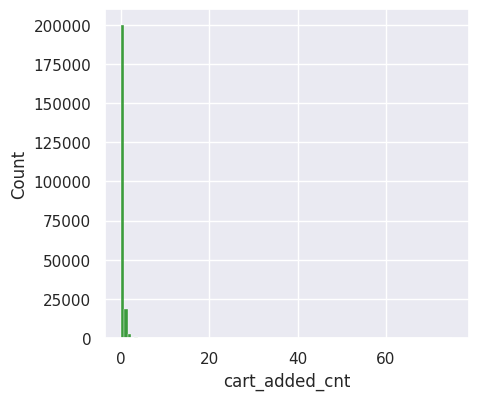

In [58]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

### Применим ранговую трансформацию (потом t-test) и сравним с результатами по Манну-Уитни на:

* метрике cart_added_cnt (1 балл)

In [59]:
def rank_transformation(df_a, df_b, metric):
    
    # Concatenate DataFrames without modifying the original ones
    df_combined = pd.concat([df_a, df_b], axis=0).copy()
    
    # Rank the combined DataFrame based on the metric
    df_combined['rank'] = df_combined[metric].rank()
    
    return df_combined

In [60]:
ranked = rank_transformation(
    shop_metrics_new[shop_metrics_new.group == 'A'],
    shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt'
)

In [61]:
def print_ttest_result(ttest_result):
    print("T-тест:")
    print("Статистика t: {:.2f}".format(ttest_result.statistic))
    print("P-значение: {:.4f}".format(ttest_result.pvalue))
    print("Степени свободы: {:.1f}".format(ttest_result.df))


result = stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])
print_ttest_result(result)

T-тест:
Статистика t: -1.27
P-значение: 0.2025
Степени свободы: 222519.0


**Различий в двух группах нет**

In [62]:
def print_mannwhitneyu_result(mannwhitneyu_result):
    print("Тест Манна-Уитни:")
    print("Статистика U: {:.1f}".format(mannwhitneyu_result.statistic))
    print("P-значение: {:.4f}".format(mannwhitneyu_result.pvalue))


result = stats.mannwhitneyu(
    shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
    shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt']
)
print_mannwhitneyu_result(result)

Тест Манна-Уитни:
Статистика U: 6179368188.5
P-значение: 0.2025


Посмотрим на мощность

In [63]:
shop = shop_metrics_new.drop(columns=['group'])

In [64]:
def check_uniform(p_values, alpha=0.05):
    """
    Проверяет, является ли набор p-values равномерно распределенным.

    Аргументы:
    p_values : list или array
        Список или массив p-values для проверки.
    alpha : float, optional
        Уровень значимости для теста Колмогорова-Смирнова. По умолчанию 0.05.

    Возвращает:
    str
        Строка, сообщающая о результате проверки.
    """

    # Проводим тест Колмогорова-Смирнова на равномерность распределения
    stat, p_value = scipy.stats.kstest(p_values, 'uniform')

    # Проверяем, является ли p-value меньше заданного уровня значимости
    if p_value < alpha:
        return f'p_value = {p_value:.4f} - p_values не соответствует равномерному распределению'
    else:
        return f'p_value = {p_value:.4f} - p_values соответствует равномерному распределению'


Мощность критерия Манну-Уитни:

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


p_value = 0.1815 - p_values соответствует равномерному распределению
 power: 100.0% , correctness: 95.0%


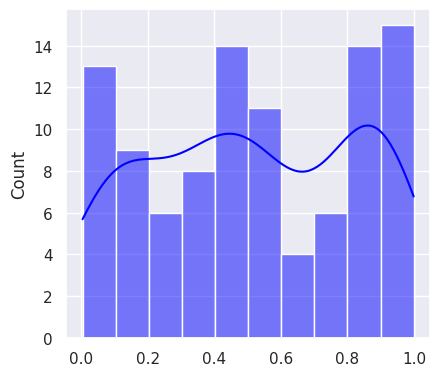

In [65]:
correctness = []
power = []
correctness_mw = []
power_mw = []

for _ in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')
    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']
    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)
    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    p_cor_mw, p_power_mw = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)
    correctness_mw.append(p_cor_mw)
    power_mw.append(p_power_mw)

correctness = np.array(correctness)
correctness_mw = np.array(correctness_mw)

sns.set_theme(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
power_mw = np.array(power_mw)

print(check_uniform(correctness))
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

**Мощность и корректность критериев также равны**

## Реализовать cuped-трансформацию и сравнить мощность t-критерия на:

* обычной метрике cart_added_cnt
* логарфимированной метрике cart_added_cnt
* метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (3 балла)

In [66]:
def cuped_transform(df: pd.DataFrame, metrics):
    """
    Применяет метод контролируемой уменьшающей ошибку дисперсии (CUPED) к указанным метрикам в DataFrame.

    Аргументы:
    df : DataFrame
        DataFrame, к которому применяется преобразование.
    metrics : list
        Список имен метрик, к которым будет применено преобразование.

    Возвращает:
    DataFrame
        Преобразованный DataFrame.
    """

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)
    df_mini = df.fillna(0)

    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')

        # Вычисление среднего значения ковариативной переменной
        mean_covariate = df_mini[covariate_column].mean()
        theta = (df_mini[m].cov(df_mini[covariate_column])) / (df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)
    return df.drop_duplicates()

In [67]:
# Объединяем новые и старые метрики магазина
shop_metrics_all = pd.merge(
    shop_metrics_new, 
    shop_metrics_old[['user_id', 'cart_added_cnt']], 
    on=['user_id'], 
    how='left')

# Переименовываем столбцы для удобства восприятия
shop_metrics_all = shop_metrics_all\
    .rename(
        columns={
            'cart_added_cnt_x': 'cart_added_cnt', 
            'cart_added_cnt_y': 'cart_added_cnt_covariate'
        }
    )


In [68]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

/tmp/ipykernel_389426/2895662416.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [69]:
shop_metrics_all_cuped.head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761


In [70]:
def print_group_mean_var(df, metric):
    """
    Выводит средние и дисперсии метрик для групп A и B, как с применением CUPED, так и без него.

    Аргументы:
    df : DataFrame
        DataFrame с данными.
    metric : str
        Название метрики.

    Возвращает:
    None
    """
    # Вычисляем средние и дисперсии для групп A и B с CUPED и без него
    group_a_mean = round(df[df.group == "A"][metric].mean(), 4)
    group_b_mean = round(df[df.group == "B"][metric].mean(), 4)
    group_a_var = round(df[df.group == "A"][metric].var(), 4)
    group_b_var = round(df[df.group == "B"][metric].var(), 4)
    group_a_cuped_mean = round(df[df.group == "A"][f"{metric}_cuped"].mean(), 4)
    group_b_cuped_mean = round(df[df.group == "B"][f"{metric}_cuped"].mean(), 4)
    group_a_cuped_var = round(df[df.group == "A"][f"{metric}_cuped"].var(), 4)
    group_b_cuped_var = round(df[df.group == "B"][f"{metric}_cuped"].var(), 4)

    # Выводим результаты
    print('Сравним средние:')
    print(f"Метрика с CUPED в группе A: {group_a_cuped_mean}, Метрика с CUPED в группе B: {group_b_cuped_mean}")
    print(f"Метрика без CUPED в группе A: {group_a_mean}, Метрика без CUPED в группе B: {group_b_mean}")
    print('\nСравним дисперсии:')
    print(f"Дисперсия метрики с CUPED в группе A: {group_a_cuped_var}, Дисперсия метрики с CUPED в группе B: {group_b_cuped_var}")
    print(f"Дисперсия метрики без CUPED в группе A: {group_a_var}, Дисперсия метрики без CUPED в группе B: {group_b_var}")
    print(f"Разница дисперсии метрики и метрики с CUPED в группе A: {group_a_var - group_a_cuped_var}")
    print(f"Разница дисперсии метрики и метрики с CUPED в группе B: {group_b_var - group_b_cuped_var}")

# Применяем функцию к DataFrame и метрике
print_group_mean_var(shop_metrics_all_cuped, 'cart_added_cnt')


Сравним средние:
Метрика с CUPED в группе A: 0.1364, Метрика с CUPED в группе B: 0.1372
Метрика без CUPED в группе A: 0.135, Метрика без CUPED в группе B: 0.1386

Сравним дисперсии:
Дисперсия метрики с CUPED в группе A: 0.0182, Дисперсия метрики с CUPED в группе B: 0.0215
Дисперсия метрики без CUPED в группе A: 0.3806, Дисперсия метрики без CUPED в группе B: 0.4247
Разница дисперсии метрики и метрики с CUPED в группе A: 0.3624
Разница дисперсии метрики и метрики с CUPED в группе B: 0.4032


Как для группы A, так и для группы B, средние значения метрик с применением CUPED немного выше, чем средние значения метрик без CUPED. Также видно, что дисперсии метрик с применением CUPED меньше, чем дисперсии метрик без CUPED, как для группы A, так и для группы B. Разница в дисперсиях между метриками без CUPED и с CUPED также значительна.

Применение метода CUPED помогло снизить дисперсию метрик в обеих группах. 

### t-test на измененной метрике

In [71]:
# Проводим t-тест
t_statistic, t_p_value = stats.ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)


print("T-тест:")
print(f"Статистика t: {t_statistic:.2f}")
print(f"P-значение: {t_p_value:.4f}")
print(f"Степени свободы: {len(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']) + len(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']) - 2:.1f}")
print()

T-тест:
Статистика t: -1.39
P-значение: 0.1659
Степени свободы: 222519.0



**t-test также указывает на отсутствие значимых различий**

### Посмотрим на мощность при эффекте в 1%

In [ ]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    vec_b_effect = vec_b * 1.01
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]

    correctness.append(p_cor)
    power.append(p_power)

p_value = 0.3844 - p_values соответствует равномерному распределению
power: 52.0% , correctness: 93.0%


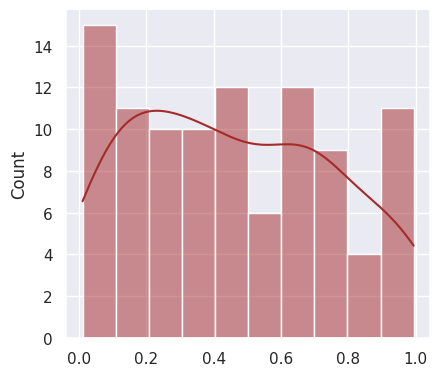

In [73]:
correctness = np.array(correctness)
power = np.array(power)
sns.set_theme(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)
print(check_uniform(correctness))
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')


### Логарифмирование

In [75]:
# Прологарифмируем метрики с добавлением 1 для предотвращения логарифма нуля
shop_metrics_all['cart_added_cnt_ln'] = np.log(shop_metrics_all['cart_added_cnt'] + 1)
shop_metrics_all['cart_added_cnt_ln_covariate'] = np.log(shop_metrics_all['cart_added_cnt_covariate'] + 1)

# Трансформируем метрику с применением CUPED
shop_metrics_all_ln_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt_ln'])

/tmp/ipykernel_389426/2895662416.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.08000403 0.08000403 0.08000403 ... 0.08000403 0.08000403 0.08000403]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [76]:
# Проводим t-тест
t_statistic, t_p_value = stats.ttest_ind(
    shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'A']['cart_added_cnt_ln'],
    shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'B']['cart_added_cnt_ln']
)


print("T-тест:")
print(f"Статистика t: {t_statistic:.2f}")
print(f"P-значение: {t_p_value:.4f}")
print(f"Степени свободы: {len(shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'A']) + len(shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'B']) - 2:.1f}")
print()

T-тест:
Статистика t: -1.45
P-значение: 0.1460
Степени свободы: 222519.0



**p-value снизилось, на группы по-прежнему не имеют значимых отличий.**

### Сравним средние в измененной метрике и дисперсии

In [77]:
print_group_mean_var(shop_metrics_all_ln_cuped, 'cart_added_cnt_ln')

Сравним средние:
Метрика с CUPED в группе A: 0.0803, Метрика с CUPED в группе B: 0.0807
Метрика без CUPED в группе A: 0.0797, Метрика без CUPED в группе B: 0.0813

Сравним дисперсии:
Дисперсия метрики с CUPED в группе A: 0.0021, Дисперсия метрики с CUPED в группе B: 0.0018
Дисперсия метрики без CUPED в группе A: 0.0647, Дисперсия метрики без CUPED в группе B: 0.0663
Разница дисперсии метрики и метрики с CUPED в группе A: 0.06259999999999999
Разница дисперсии метрики и метрики с CUPED в группе B: 0.0645


Посмотрим на мощность:

In [ ]:
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    all_df['cart_added_cnt_ln'] = np.log(all_df['cart_added_cnt'] + 1)
    all_df['cart_added_cnt_ln_covariate'] = np.log(all_df['cart_added_cnt_covariate'] + 1)

    cuped_df = cuped_transform(all_df, ['cart_added_cnt_ln'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_ln_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_ln_cuped']
    vec_b_effect = vec_b * np.log(1.01)

    # vec_b_effect_ln = np.log(vec_b_effect + 1)

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

p_value = 0.2710 - p_values соответствует равномерному распределению
 power: 100.0% , correctness: 96.0%


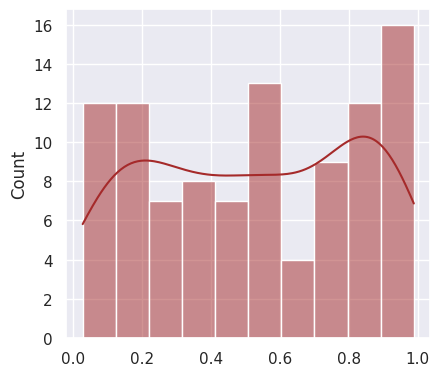

In [83]:
correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
print(check_uniform(correctness))

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

## Реализовать cuped-трансформацию на метрике cart_added_cnt и подвергнем ее ранговому преобразованию

In [84]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

ranked = rank_transformation(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped'
)

/tmp/ipykernel_389426/2895662416.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [86]:
# Проводим t-тест
t_statistic, t_p_value = stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])


print("T-тест:")
print(f"Статистика t: {t_statistic:.2f}")
print(f"P-значение: {t_p_value:.4f}")
print(f"Степени свободы: {len(shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'A']) + len(shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'B']) - 2:.1f}")
print()

T-тест:
Статистика t: -1.45
P-значение: 0.1482
Степени свободы: 222519.0



In [ ]:
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    ranked = rank_transformation(cuped_df[cuped_df.group == 'A'],
                                 cuped_df[cuped_df.group == 'B'], 'cart_added_cnt_cuped')

    vec_a = ranked[(ranked['group'] == 'A')]['rank']
    vec_b = ranked[(ranked['group'] == 'B')]['rank']
    vec_b_effect = vec_b * 1.01

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

p_value = 0.7779 - p_values соответствует равномерному распределению
 power: 100.0% , correctness: 95.0%


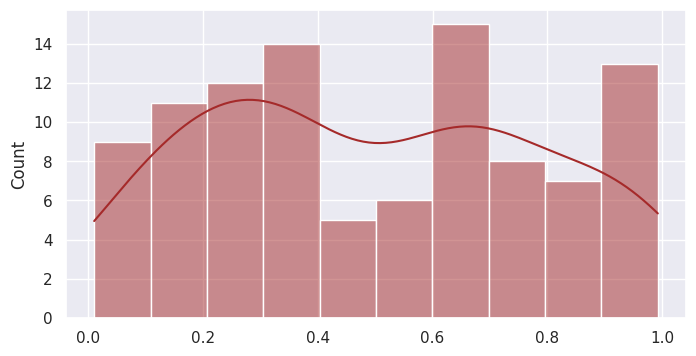

In [89]:
correctness = np.array(correctness)
sns.set_theme(rc={'figure.figsize':(8,4)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
print(check_uniform(correctness))
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

#### Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:

* на логнормальном распределении (сгенерированные данные)
* на метрике cart_added_cnt (2 балла)

In [91]:
# Генерируем логнормальное распределение
data = np.random.lognormal(0, 1, 100_000)

# Разбиваем данные на равные бакеты
num_buckets = 10000
sorted_data = np.sort(data)
percentiles = np.linspace(0, 100, num_buckets + 1)
bucket_edges = np.percentile(sorted_data, percentiles)
buckets = [sorted_data[(sorted_data >= bucket_edges[i]) & (sorted_data < bucket_edges[i + 1])] for i in range(num_buckets)]

# Берем среднее значение для каждого бакета
bucket_means = [np.mean(bucket) for bucket in buckets]

# Создаем DataFrame для данных и средних значений бакетов
data = pd.DataFrame({"user_id": np.arange(len(data)), "metric": data})
data_bucket_means = pd.DataFrame({"user_id": np.arange(len(bucket_means)), "metric": bucket_means})

data_bucket_means.head()

,user_id,metric
0,0,0.021062
1,1,0.026970
2,2,0.030553
3,3,0.034037
4,4,0.036978


### без бакетирования:

In [94]:
correctness = []
power = []

for _ in tqdm(range(100)):
    new_group = groups_splitter(data.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(data, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df.loc[new_df['group'] == 'A', 'metric']
    vec_b = new_df.loc[new_df['group'] == 'B', 'metric']

    vec_b_effect = vec_b * 1.03

    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    correctness.append(p_cor)
    power.append(p_power)


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


 power: 98.0% , correctness: 93.0%


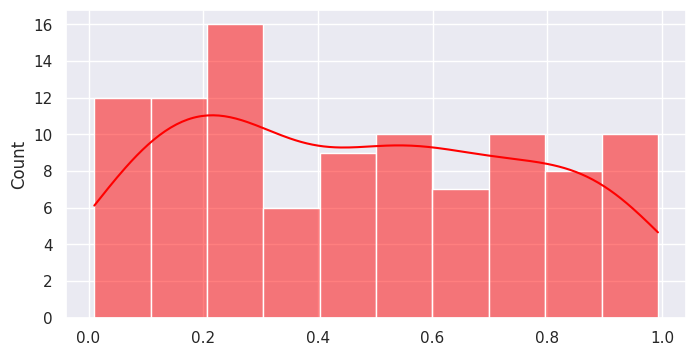

In [107]:
correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='red', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

С бакетированием:

In [109]:
correctness = []
power = []

for _ in tqdm(range(100)):
    new_group = groups_splitter(data_bucket_means.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(data_bucket_means, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df.loc[new_df['group'] == 'A', 'metric']
    vec_b = new_df.loc[new_df['group'] == 'B', 'metric']

    vec_b_effect = vec_b * 1.03

    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    correctness.append(p_cor)
    power.append(p_power)

100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


 power: 22.0% , correctness: 96.0%


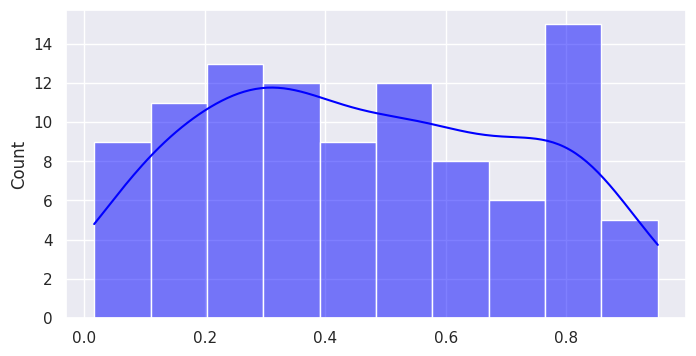

In [111]:
correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Мощность значительно упала

## Реализуем разбивку на бакеты на метрике cart_added_cnt

In [112]:
def get_bucket(df, metric, bucket_size):
    df_sorted = df.sort_values(by=metric).reset_index(drop=True)
    bucket_size = len(df_sorted) // bucket_size
    df_sorted['bucket'] = pd.qcut(df_sorted.index, q=bucket_size, labels=False, duplicates='drop')
    df_bucketed = df_sorted.groupby('bucket', as_index=False)[metric].mean()
    df_bucketed = df_bucketed.rename(columns={"bucket": "user_id"})
    
    return df_bucketed


In [114]:
bucket_sizes = [100, 1000, 10000]
correctness = [[] for _ in range(len(bucket_sizes))]
powers = [[] for _ in range(len(bucket_sizes))]

for idx, bucket_size in enumerate(bucket_sizes):
    shop_bucket = get_bucket(shop.copy(), 'cart_added_cnt', bucket_size)

    for _ in tqdm(range(100)):
        new_group = groups_splitter(shop.copy(),  columns=['user_id', 'group'], user_salt=generate_salt())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

        vec_a = new_df.loc[new_df['group'] == 'A', 'cart_added_cnt']
        vec_b = new_df.loc[new_df['group'] == 'B', 'cart_added_cnt']
        vec_b_effect = vec_b * 1.03

        p_cor = stats.ttest_ind(vec_a, vec_b)[1]
        p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

        correctness[idx].append(p_cor)
        powers[idx].append(p_power)

    correctness[idx] = np.array(correctness[idx])
    powers[idx] = np.array(powers[idx])

    check_uniform(correctness[idx])

    power_significance = (powers[idx] < 0.05).mean() * 100
    correctness_significance = (correctness[idx] < 0.05).mean() * 100

    print(f'Мощность при bucket_size = {bucket_size}: {power_significance:.2f}%')
    print(f'Корректность при bucket_size = {bucket_size}: {(1 - correctness_significance / 100) * 100:.2f}% \n')


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Мощность при bucket_size = 100: 33.00%
Корректность при bucket_size = 100: 96.00% 



100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Мощность при bucket_size = 1000: 37.00%
Корректность при bucket_size = 1000: 95.00% 



100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

Мощность при bucket_size = 10000: 32.00%
Корректность при bucket_size = 10000: 96.00% 



Из результатов эксперимента видно, что при увеличении размера бакетов (bucket_size) мощность (power) увеличивается, но не значительно. С другой стороны, корректность (correctness) остается примерно на том же уровне при различных значениях bucket_size.

Это может означать, что разбиение на более крупные бакеты может увеличить мощность теста, но это может сопровождаться уменьшением точности в определении различий между группами, что отражается на корректности теста.

## Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:

на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) подсчитать результаты для случая без постстратификации и с постстратификацией
проверить мощность и корректность t-критерия для постстратифицированного случая (2 балла)

In [115]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')

In [116]:
def age_group(age):
    # Simplifying condition checks using chained comparisons
    if 18 <= age <= 24:
        return '18-24'
    elif 25 <= age <= 45:
        return '25-45'
    elif 46 <= age <= 60:
        return '46-60'
    elif 61 <= age <= 75:
        return '61-75'
    else:
        return '76+'

In [118]:
def get_mean_std_n(df):
    df['age_group'] = df['user_age'].apply(age_group)
    df['strats'] = df['user_sex'] + '_' + df['age_group']
    N = df['user_id'].nunique()
    strats_weights = df['strats'].value_counts() / N

    mean_a, mean_b = 0, 0
    var_a, var_b = 0, 0

    for strata in df['strats'].unique():
        mask_a = (df['group'] == 'A') & (df['strats'] == strata)
        mask_b = (df['group'] == 'B') & (df['strats'] == strata)
        
        mean_a += df[mask_a]['cart_added_cnt'].mean() * strats_weights[strata]
        mean_b += df[mask_b]['cart_added_cnt'].mean() * strats_weights[strata]
        var_a += df[mask_a]['cart_added_cnt'].var() * strats_weights[strata]
        var_b += df[mask_b]['cart_added_cnt'].var() * strats_weights[strata]

    std_a = (var_a**0.5)
    std_b = (var_b**0.5)

    n_a = len(df[df.group == 'A'])
    n_b = len(df[df.group == 'B'])

    return mean_a, mean_b, std_a, std_b, n_a, n_b

mean_a, mean_b, std_a, std_b, n_a, n_b = get_mean_std_n(shop_w_features)

effect_percent = ((mean_b - mean_a) / mean_a) * 100
t_stat, p_value = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b * 1.03, std_b, n_b)

print(f'Эффект: {effect_percent:.2f}%')
print(f'Статистика t: {t_stat:.2f}')
print(f'P-значение: {p_value:.4f}')
print(f'Степени свободы: {n_a + n_b - 2}')


Эффект: 1.12%
Статистика t: -2.71
P-значение: 0.0067
Степени свободы: 406861


**Эффект составляет 1.12%, что указывает на небольшое увеличение среднего значения метрики 'cart_added_cnt' в группе B по сравнению с группой A. Статистика t равна -2.71, а p-значение равно 0.0067, что говорит о статистической значимости различия между группами. Вместе с высокими степенями свободы (406861), это подтверждает статистическую значимость различия между группами.**

In [ ]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop_w_features.copy(), columns=['user_id', 'group'], user_salt=generate_salt())
    new_df = pd.merge(shop_w_features.drop('group', axis=1), new_group, how="left", on=['user_id']).drop_duplicates()

    mean_a, mean_b, std_a, std_b, n_a, n_b = get_mean_std_n(new_df)

    p_cor = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]

    # Изменяем метрику в группе B
    new_df.loc[new_df['group'] == 'B', 'cart_added_cnt'] *= 1.01

    mean_a, mean_b, std_a, std_b, n_a, n_b = get_mean_std_n(new_df)

    p_power = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]

    correctness.append(p_cor)
    power.append(p_power)

p_value = 0.9540 - p_values соответствует равномерному распределению
power: 12.0% , correctness: 95.0%


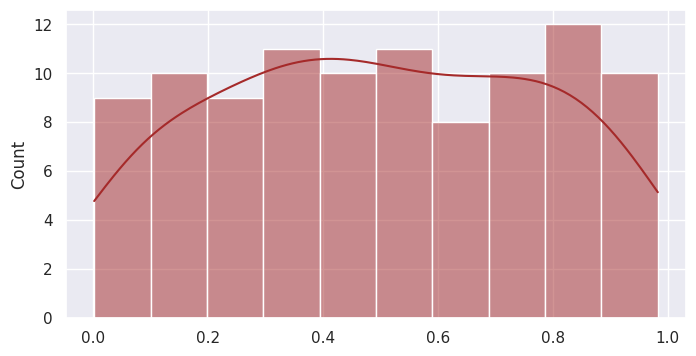

In [122]:
correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
print(check_uniform(correctness))
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')